<a href="https://colab.research.google.com/github/Chan2101/crops/blob/main/Chan_MRP_Experiments_Models_Final_revision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob

BASE = "/content/drive/MyDrive/test_chan"
print("Checking folder:", BASE)

print("CSV files found:")
print("\n".join(glob.glob(os.path.join(BASE, "*.csv"))))

print("\nXLSX files found:")
print("\n".join(glob.glob(os.path.join(BASE, "*.xlsx"))))

WEATHER_FILE = os.path.join(BASE, "aggregated_weather_by_region_year.csv")
DISEASE_FILE = os.path.join(BASE, "mean-time-series-wheat-regional-data-september-2024-1.xlsx")

for p in (WEATHER_FILE, DISEASE_FILE):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Not found: {p}\nCheck the filename or BASE path above.")

print("Using:")
print("  WEATHER_FILE:", WEATHER_FILE)
print("  DISEASE_FILE:", DISEASE_FILE)

import pandas as pd

weather = pd.read_csv(WEATHER_FILE)
disease = pd.read_excel(DISEASE_FILE, skiprows=1)

print(weather.shape, disease.shape)
weather.head(), disease.head()


Mounted at /content/drive
Checking folder: /content/drive/MyDrive/test_chan
CSV files found:
/content/drive/MyDrive/test_chan/weather_daily_uk_regions.csv
/content/drive/MyDrive/test_chan/aggregated_weather_by_region_year.csv

XLSX files found:
/content/drive/MyDrive/test_chan/mean-time-series-wheat-regional-data-september-2024-1.xlsx
/content/drive/MyDrive/test_chan/mean-time-series-wheat-national-data-september-2024-2.xlsx
/content/drive/MyDrive/test_chan/mean-time-series-osr-national-data-september-2024-1.xlsx
Using:
  WEATHER_FILE: /content/drive/MyDrive/test_chan/aggregated_weather_by_region_year.csv
  DISEASE_FILE: /content/drive/MyDrive/test_chan/mean-time-series-wheat-regional-data-september-2024-1.xlsx
(460, 15) (456, 33)


(  region  year  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
 0   East  1979           53.787471           41.508512            47.711669   
 1   East  1980           54.440029           42.801013            48.640552   
 2   East  1981           54.237224           41.923005            48.224813   
 3   East  1982           55.935142           43.318622            49.731152   
 4   East  1983           55.953635           43.436238            49.642529   
 
    apparent_temperature_max  apparent_temperature_min  \
 0                 47.904956                 35.368731   
 1                 48.713031                 36.767916   
 2                 48.566656                 35.856227   
 3                 50.575717                 37.687323   
 4                 50.509340                 37.538633   
 
    apparent_temperature_mean    rain_sum  snowfall_sum  precipitation_hours  \
 0                  41.708643  620.400003     67.830000               1452.0   
 1      

In [25]:

from google.colab import drive
drive.mount('/content/drive')
BASE = "/content/drive/MyDrive/test_chan"
WEATHER_FILE = BASE + "/aggregated_weather_by_region_year.csv"
DISEASE_FILE = BASE + "/mean-time-series-wheat-regional-data-september-2024-1.xlsx"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
TARGET_DISEASE = "Zymoseptoria_tritici"
OUTDIR = "./figs_results"
os.makedirs(OUTDIR, exist_ok=True)

#Load
weather = pd.read_csv(WEATHER_FILE)
disease = pd.read_excel(DISEASE_FILE, skiprows=1)
disease.columns = disease.columns.str.strip().str.replace(" ", "_")

disease = disease[['Region', 'Survey_year', TARGET_DISEASE]].dropna()
disease.columns = ['region', 'year', 'DiseaseSeverity']

#Merge
df = weather.merge(disease, on=['region', 'year'], how='inner').dropna()

print("Weather shape:", weather.shape)
print("Disease shape:", disease.shape)
print("Merged shape :", df.shape)
df.head()



Weather shape: (460, 15)
Disease shape: (456, 3)
Merged shape : (374, 16)


,region,year,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration,DiseaseSeverity
0,East,1979,53.787471,41.508512,47.711669,47.904956,35.368731,41.708643,620.400003,67.830000,1452.0,14.165632,25.941233,9.947288,1.710049,0.282
1,East,1980,54.440029,42.801013,48.640552,48.713031,36.767916,42.779867,726.200000,22.400001,1431.0,14.121566,26.171678,9.503443,1.668485,0.127
2,East,1981,54.237224,41.923005,48.224813,48.566656,35.856227,42.361025,600.700004,65.169996,1370.0,14.243198,26.497112,9.238904,1.628202,0.665
3,East,1982,55.935142,43.318622,49.731152,50.575717,37.687323,44.251440,654.900009,8.119999,1254.0,13.947657,26.266670,10.083699,1.797908,0.005
4,East,1985,53.842950,42.085745,47.944570,48.086449,36.028138,42.082730,578.500004,28.140002,1346.0,14.123781,26.148998,9.581397,1.636295,7.722


In [27]:

def eval_regression(y_true, y_pred):
    return {
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

def save_metrics_table(results_dict, out_csv):
    rows = []
    for exp_name, m in results_dict.items():
        row = {"Experiment": exp_name}
        row.update(m)
        rows.append(row)
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print("💾 Saved metrics table to:", out_csv)

def plot_metrics_bar(results_dict, out_r2_png):
    exps = list(results_dict.keys())
    r2s = [results_dict[k]["R2"] for k in exps]
    rmses = [results_dict[k]["RMSE"] for k in exps]

    # R2 bar
    plt.figure(figsize=(8,4))
    plt.bar(exps, r2s)
    plt.title("R² by Experiment")
    plt.ylabel("R²")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(out_r2_png, dpi=200)
    plt.show()

    # RMSE bar
    out_rmse_png = out_r2_png.replace("R2","RMSE")
    plt.figure(figsize=(8,4))
    plt.bar(exps, rmses)
    plt.title("RMSE by Experiment")
    plt.ylabel("RMSE")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(out_rmse_png, dpi=200)
    plt.show()

def run_rf_regression_and_plots(X, y, label):
    # Split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=42)
    # Train
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_tr, y_tr)
    # Predict
    y_pred = rf.predict(X_te)
    metrics = eval_regression(y_te, y_pred)

    # SHAP bar
    try:
        explainer = shap.TreeExplainer(rf)
        shap_vals = explainer.shap_values(X_te)
        shap.summary_plot(shap_vals, X_te, plot_type="bar", show=False)
        plt.title(f"SHAP Summary (bar) – {label}")
        plt.tight_layout()
        path = os.path.join(OUTDIR, f"SHAP_bar_{label}.png")
        plt.savefig(path, dpi=200)
        plt.show()
        print("💾 Saved SHAP bar to:", path)
    except Exception as e:
        print(f"[WARN] SHAP plot failed for {label}: {e}")

    # PDP/ICE for top 3 features by RF importance
    try:
        importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
        top3 = list(importances.head(3).index)
        for f in top3:
            PartialDependenceDisplay.from_estimator(rf, X_tr, [f], kind="both")
            plt.suptitle(f"PDP/ICE – {label} – {f}")
            plt.tight_layout()
            path = os.path.join(OUTDIR, f"PDP_ICE_{label}_{f}.png")
            plt.savefig(path, dpi=200)
            plt.show()
            print("💾 Saved PDP/ICE to:", path)
    except Exception as e:
        print(f"[WARN] PDP/ICE failed for {label}: {e}")

    return metrics


### Experiment 1 — Baseline (Weather + Region one-hot)

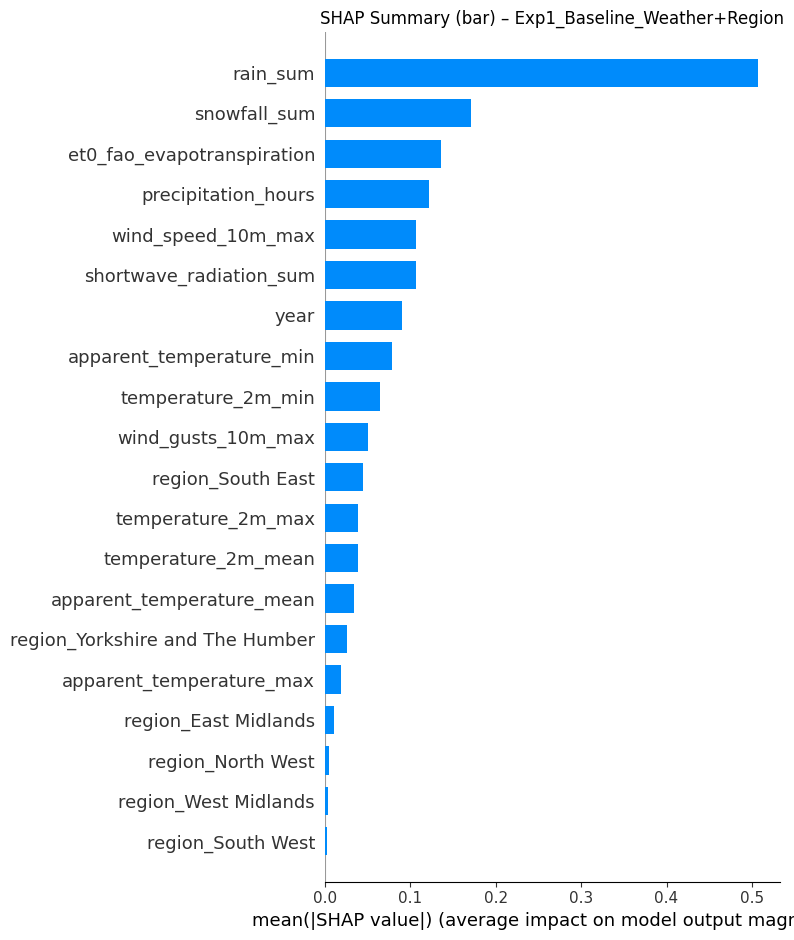

💾 Saved SHAP bar to: ./figs_results/SHAP_bar_Exp1_Baseline_Weather+Region.png


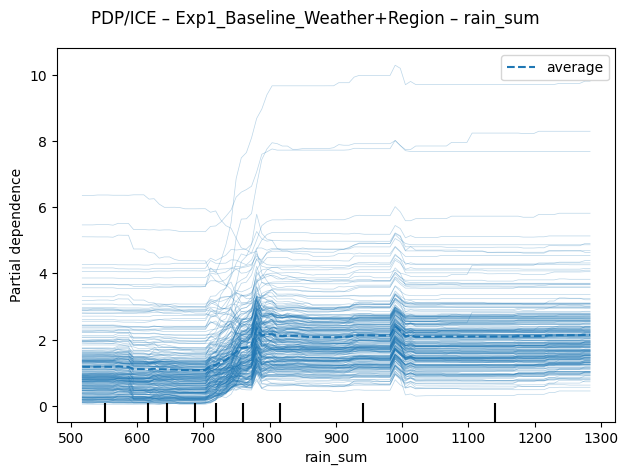

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp1_Baseline_Weather+Region_rain_sum.png


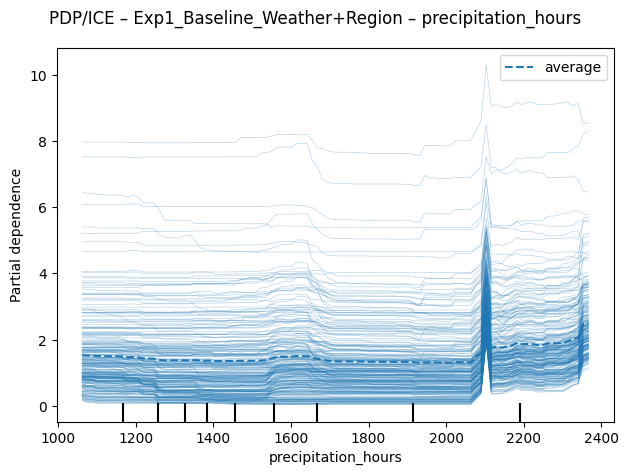

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp1_Baseline_Weather+Region_precipitation_hours.png


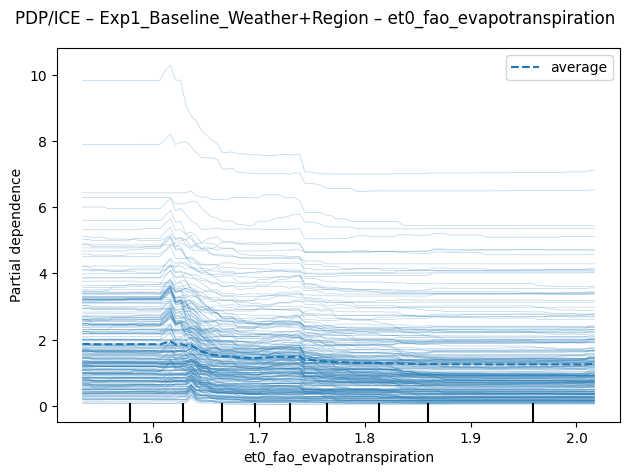

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp1_Baseline_Weather+Region_et0_fao_evapotranspiration.png


{'RMSE': 1.862488269119082,
 'MAE': 1.198836017699115,
 'R2': 0.17145751715978674}

In [28]:

results = {}

E1 = "Exp1_Baseline_Weather+Region"
X1 = df.drop(columns=['DiseaseSeverity'])
X1 = pd.get_dummies(X1, columns=['region'], drop_first=True)
y = df['DiseaseSeverity']

results[E1] = run_rf_regression_and_plots(X1, y, E1)
results[E1]


### Experiment 2 — Weather Only

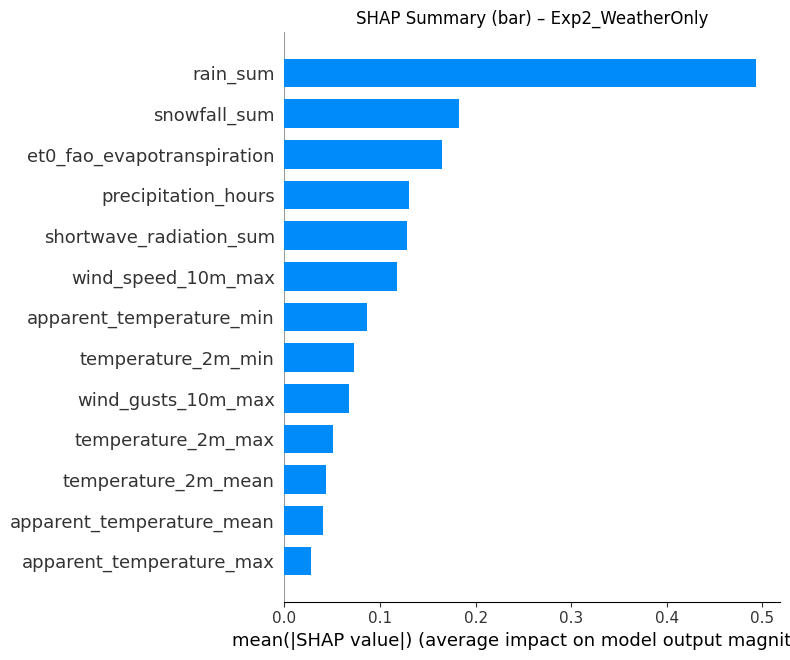

💾 Saved SHAP bar to: ./figs_results/SHAP_bar_Exp2_WeatherOnly.png


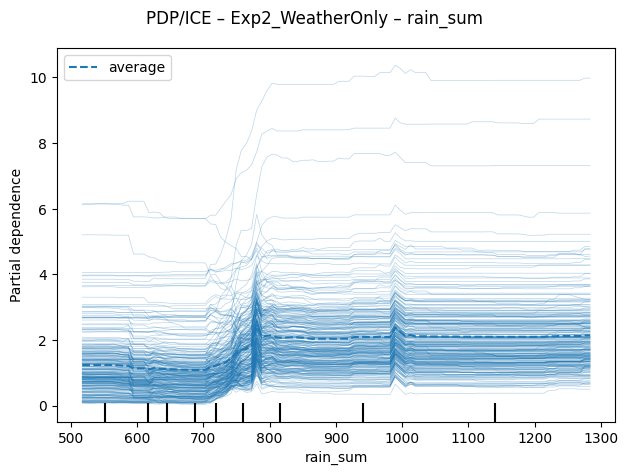

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp2_WeatherOnly_rain_sum.png


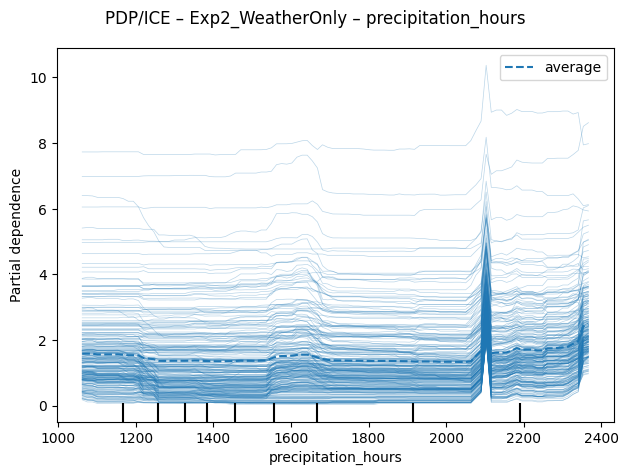

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp2_WeatherOnly_precipitation_hours.png


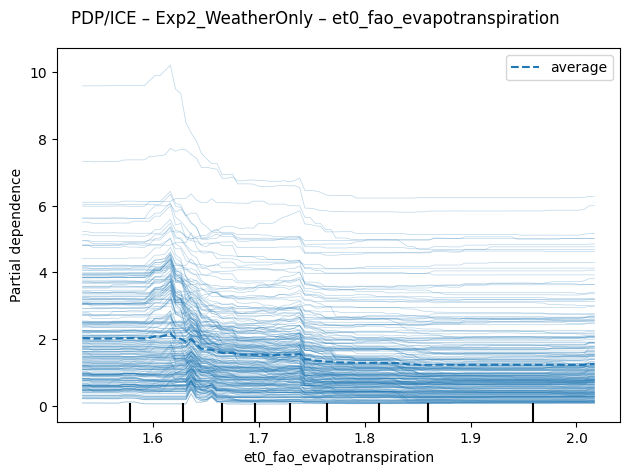

💾 Saved PDP/ICE to: ./figs_results/PDP_ICE_Exp2_WeatherOnly_et0_fao_evapotranspiration.png


{'RMSE': 1.883796773292036,
 'MAE': 1.2108799999999997,
 'R2': 0.15239055645113897}

In [29]:

E2 = "Exp2_WeatherOnly"
X2 = df.drop(columns=['DiseaseSeverity','region','year'])

results[E2] = run_rf_regression_and_plots(X2, y, E2)
results[E2]


### Experiment 3 — Per-Region Models

In [30]:

E3 = "Exp3_PerRegion"
region_scores = []
for reg in sorted(df['region'].unique()):
    sub = df[df['region']==reg]
    if len(sub) < 30:
        continue
    Xr = sub.drop(columns=['DiseaseSeverity','region','year'])
    yr = sub['DiseaseSeverity']
    X_tr, X_te, y_tr, y_te = train_test_split(Xr, yr, test_size=0.3, random_state=42)
    rf = RandomForestRegressor(random_state=42).fit(X_tr, y_tr)
    pred = rf.predict(X_te)
    r2 = r2_score(y_te, pred)
    region_scores.append({"region": reg, "R2": r2})

region_df = pd.DataFrame(region_scores).sort_values("R2", ascending=False)
path = os.path.join(OUTDIR, "Exp3_PerRegion_R2.csv")
region_df.to_csv(path, index=False)
print("💾 Saved per-region R² table to:", path)

# store mean R2 for summary
results[E3] = {"RMSE": np.nan, "MAE": np.nan, "R2": region_df["R2"].mean() if len(region_df) else np.nan}
region_df.head(10)


💾 Saved per-region R² table to: ./figs_results/Exp3_PerRegion_R2.csv


,region,R2
0,East,-0.094024
7,Yorkshire and The Humber,-0.119637
4,South East,-0.153426
3,North West,-0.231510
2,North East,-0.237301
6,West Midlands,-0.299689
1,East Midlands,-0.327604
5,South West,-0.570681


### Experiment 4 — High-Risk Classification + Permutation Importance

ROC-AUC: 0.7357142857142858
F1     : 0.4166666666666667
💾 Saved permutation importance CSV to: ./figs_results/Exp4_PermutationImportance.csv


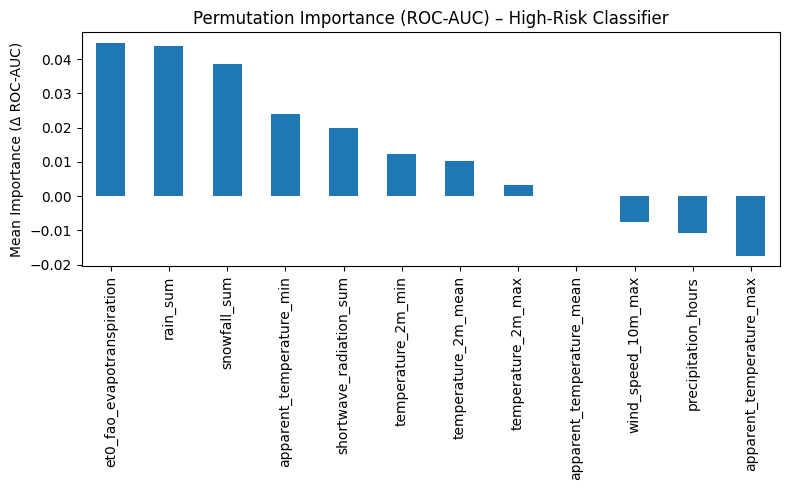

💾 Saved permutation importance plot to: ./figs_results/Exp4_PermImp_Top12.png


In [31]:

E4 = "Exp4_HighRisk_Classifier_PermImp"
thr = df['DiseaseSeverity'].quantile(0.75)
df_cls = df.copy()
df_cls["HighRisk"] = (df_cls["DiseaseSeverity"] >= thr).astype(int)

Xc = df_cls.drop(columns=['region','year','DiseaseSeverity','HighRisk'])
yc = df_cls['HighRisk']

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.3, random_state=42, stratify=yc)
clf = HistGradientBoostingClassifier(random_state=42)
clf.fit(Xc_tr, yc_tr)

proba = clf.predict_proba(Xc_te)[:,1]
pred  = (proba >= 0.5).astype(int)

roc = roc_auc_score(yc_te, proba)
f1  = f1_score(yc_te, pred)
print("ROC-AUC:", roc)
print("F1     :", f1)

# Permutation importance
perm = permutation_importance(clf, Xc_te, yc_te, n_repeats=15, random_state=42, scoring='roc_auc')
perm_series = pd.Series(perm.importances_mean, index=Xc.columns).sort_values(ascending=False)
perm_csv = os.path.join(OUTDIR, "Exp4_PermutationImportance.csv")
perm_series.to_csv(perm_csv)
print("💾 Saved permutation importance CSV to:", perm_csv)

plt.figure(figsize=(8,5))
perm_series.head(12).plot(kind='bar')
plt.title("Permutation Importance (ROC-AUC) – High-Risk Classifier")
plt.ylabel("Mean Importance (Δ ROC-AUC)")
plt.tight_layout()
perm_png = os.path.join(OUTDIR, "Exp4_PermImp_Top12.png")
plt.savefig(perm_png, dpi=200)
plt.show()
print("💾 Saved permutation importance plot to:", perm_png)

# store ROC in R2 slot for unified summary plotting
results[E4] = {"RMSE": np.nan, "MAE": np.nan, "R2": roc}


## 💾 Save Metrics Summary + Bar Charts

💾 Saved metrics table to: ./figs_results/metrics_summary.csv


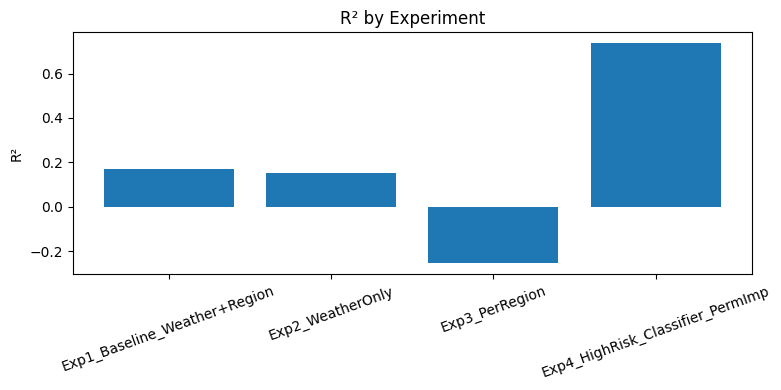

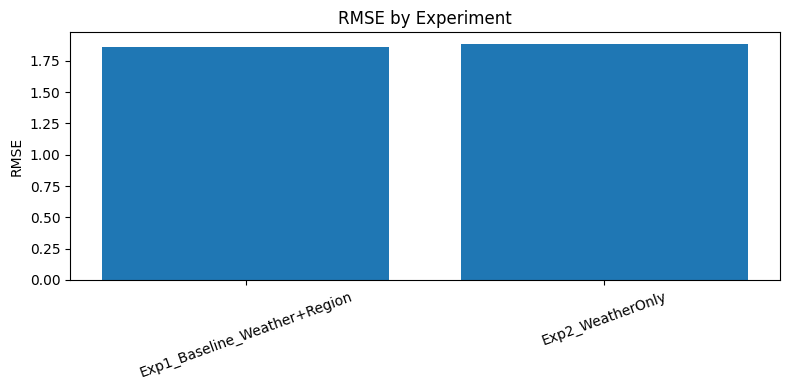

✅ Done. See figures and tables in: ./figs_results


In [32]:

def plot_metrics_bar(results_dict, out_r2_png):
    exps = list(results_dict.keys())
    r2s = [results_dict[k]["R2"] for k in exps]
    rmses = [results_dict[k]["RMSE"] for k in exps]

    # R2 bar
    plt.figure(figsize=(8,4))
    plt.bar(exps, r2s)
    plt.title("R² by Experiment")
    plt.ylabel("R²")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(out_r2_png, dpi=200)
    plt.show()

    # RMSE bar
    out_rmse_png = out_r2_png.replace("R2","RMSE")
    plt.figure(figsize=(8,4))
    plt.bar(exps, rmses)
    plt.title("RMSE by Experiment")
    plt.ylabel("RMSE")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.savefig(out_rmse_png, dpi=200)
    plt.show()

metrics_csv = os.path.join(OUTDIR, "metrics_summary.csv")
save_metrics_table(results, metrics_csv)

plot_metrics_bar(results, os.path.join(OUTDIR, "R2_by_Experiment.png"))
print("✅ Done. See figures and tables in:", OUTDIR)
